In [2]:
# for loading/processing the images  
from tensorflow.keras.preprocessing.image import load_img 
from tensorflow.keras.preprocessing.image import img_to_array 
from tensorflow.keras.applications.vgg16 import preprocess_input 

# models 
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle

In [3]:
path = os.getcwd() + "\..\Dataset"
# this list holds all the image filename
pottery = []

# Define a function to recursively walk through directories
def collect_images(directory):
    # Use os.scandir() to list files in the current directory
    with os.scandir(directory) as entries:
        for entry in entries:
            # If it's a directory, recurse into it
            if entry.is_dir():
                collect_images(entry.path)
            # If it's a file, check if it's an image file
            elif entry.is_file() and entry.name.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp')):
                # Add the image file to the list
                pottery.append(entry.path)

collect_images(path)

print(pottery[:10])
n_images = len(pottery)
print(f"There are {n_images} images in the dataset")

['c:\\Users\\brayk\\Documents\\CMU-Classes\\interp\\Contribution\\Code\\..\\Dataset\\Banpo\\Banpo_1.jpg', 'c:\\Users\\brayk\\Documents\\CMU-Classes\\interp\\Contribution\\Code\\..\\Dataset\\Banpo\\Banpo_10.jpg', 'c:\\Users\\brayk\\Documents\\CMU-Classes\\interp\\Contribution\\Code\\..\\Dataset\\Banpo\\Banpo_100.jpg', 'c:\\Users\\brayk\\Documents\\CMU-Classes\\interp\\Contribution\\Code\\..\\Dataset\\Banpo\\Banpo_101.jpg', 'c:\\Users\\brayk\\Documents\\CMU-Classes\\interp\\Contribution\\Code\\..\\Dataset\\Banpo\\Banpo_102.jpg', 'c:\\Users\\brayk\\Documents\\CMU-Classes\\interp\\Contribution\\Code\\..\\Dataset\\Banpo\\Banpo_103.jpg', 'c:\\Users\\brayk\\Documents\\CMU-Classes\\interp\\Contribution\\Code\\..\\Dataset\\Banpo\\Banpo_104.jpg', 'c:\\Users\\brayk\\Documents\\CMU-Classes\\interp\\Contribution\\Code\\..\\Dataset\\Banpo\\Banpo_105.jpg', 'c:\\Users\\brayk\\Documents\\CMU-Classes\\interp\\Contribution\\Code\\..\\Dataset\\Banpo\\Banpo_106.jpg', 'c:\\Users\\brayk\\Documents\\CMU-Class

In [ ]:

model = VGG19()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)
def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img) 
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, verbose=False)
    return features

Get feature data from these images by passing them through the model and save to AnalData_features (may take some time) 

In [5]:
data = {}
p = r"E:\Documents\My Projects\Instagram Dashboard\Model Development\flower_features.pkl"
q = os.getcwd() + "\..\AnalData_features"
# lop through each image in the dataset
for idx,pot in enumerate(pottery):
    if idx%100 == 0:
        print(f"{idx}/{n_images}")
    # try to extract the features and update the dictionary
    try:
        feat = extract_features(pot,model)
        data[pot] = feat
    # if something fails, save the extracted features as a pickle file (optional)
    except:
        with open(p,'wb') as file:
            pickle.dump(data,file)
          
 
# get a list of the filenames
filenames = np.array(list(data.keys()))

# get a list of just the features
feat = np.array(list(data.values()))
print(feat.shape)
feat = feat.reshape(-1,4096)
print(feat.shape)
with open(q,'wb') as file:
    pickle.dump(data,file)

0/1106


C:\Users\brayk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


100/1106
200/1106
300/1106
400/1106
500/1106
600/1106
700/1106
800/1106
900/1106
1000/1106
1100/1106
(1106, 1, 4096)
(1106, 4096)


Load feature data from AnalData_features (quick but requires this data to already exist)

In [4]:
q = os.getcwd() + "\..\AnalData_features"
with open(q, 'rb') as f:
    data = pickle.load(f)
feat = np.array(list(data.values()))
print(feat.shape)
feat = feat.reshape(-1,4096)
print(feat.shape)

(1106, 1, 4096)
(1106, 4096)


PCA reduction: find optimal reduction

[0.19847517 0.26678157 0.3199098  ... 0.999992   1.         1.        ]
Optimal number of components to explain 50.0% of the variance: 10


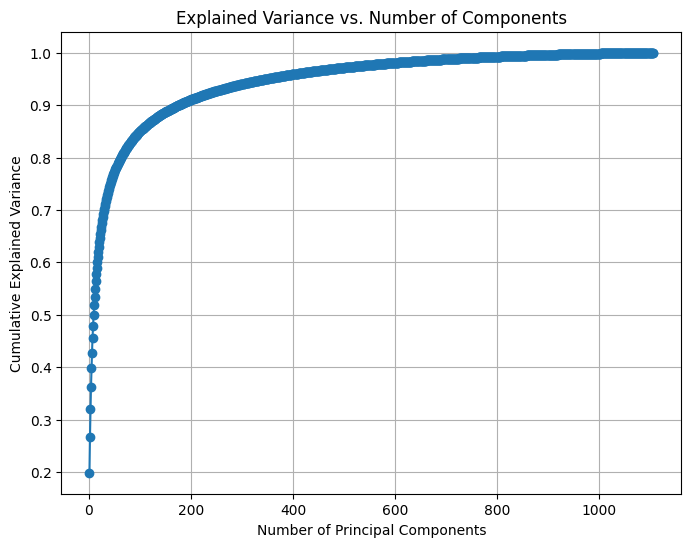

In [5]:
pca = PCA()
pca.fit(feat)
explained_variance_ratio = pca.explained_variance_ratio_
# Calculate the cumulative explained variance
cumulative_variance = np.cumsum(explained_variance_ratio)

# Print the cumulative explained variance
print(cumulative_variance)

# Choose the number of components to retain 95% of the variance
pcnt = 0.5
n_components = np.argmax(cumulative_variance >= pcnt) + 1
print(f"Optimal number of components to explain {pcnt*100}% of the variance: {n_components}")

# Plot cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

In [5]:
n_components = 3
pca = PCA(n_components=n_components, random_state=76101)
pca.fit(feat)
x = pca.transform(feat)
print(f"Components before PCA: {feat.shape[1]}")
print(f"Components after PCA: {pca.n_components}")

Components before PCA: 4096
Components after PCA: 3


Clustering Time

In [6]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score


In [7]:
silhouette_scores = []
db_scores = []
gap_scores = []
def best_k(n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=76101)
    
    kmeans.fit(x)
    #print(x[:10])

    score = silhouette_score(x, kmeans.labels_)
    silhouette_scores.append(score)

    dbi = davies_bouldin_score(x, kmeans.labels_)
    db_scores.append(dbi)
        
    print(f"Number of clusters: {n_clusters}, Silhouette Score: {score}, DBI: {dbi}")
max_k=30
for k in range(2,max_k):
    best_k(k)


Number of clusters: 2, Silhouette Score: 0.447194367647171, DBI: 0.9254811361043177
Number of clusters: 3, Silhouette Score: 0.4034210741519928, DBI: 1.0975713448642497
Number of clusters: 4, Silhouette Score: 0.39936363697052, DBI: 0.9684827580005837
Number of clusters: 5, Silhouette Score: 0.35376209020614624, DBI: 0.9966106041930436
Number of clusters: 6, Silhouette Score: 0.34728318452835083, DBI: 1.060704893770121
Number of clusters: 7, Silhouette Score: 0.3236422836780548, DBI: 1.0831371102580114
Number of clusters: 8, Silhouette Score: 0.3015669882297516, DBI: 1.1305867890027155
Number of clusters: 9, Silhouette Score: 0.28385794162750244, DBI: 1.057076619978167
Number of clusters: 10, Silhouette Score: 0.2808679938316345, DBI: 1.0634816634182431
Number of clusters: 11, Silhouette Score: 0.26689329743385315, DBI: 1.1338153161200557
Number of clusters: 12, Silhouette Score: 0.26795583963394165, DBI: 1.1340695648784267
Number of clusters: 13, Silhouette Score: 0.26766037940979004,

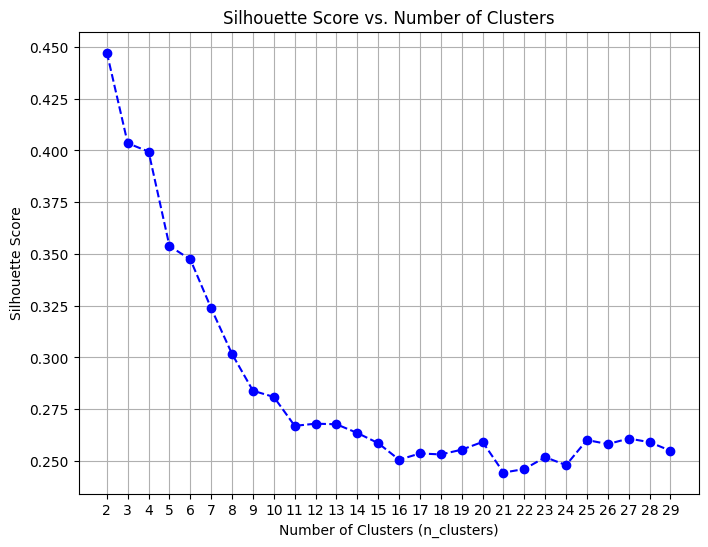

In [8]:
# Plot silhouette scores for different values of n_clusters
%matplotlib inline
plt.figure(figsize=(8, 6))
plt.plot(range(2, max_k), silhouette_scores, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Clusters (n_clusters)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.grid(True)
plt.xticks(range(2, max_k))  # Set x-ticks to be the same as the range of clusters
plt.show()

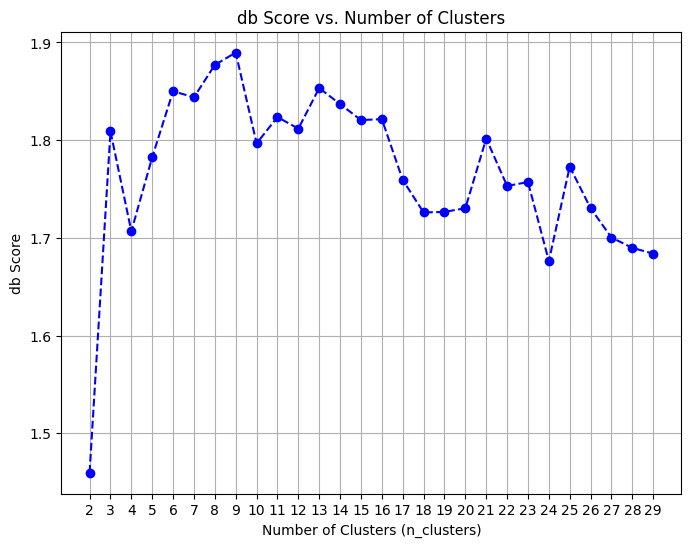

In [12]:
# Plot silhouette scores for different values of n_clusters
plt.figure(figsize=(8, 6))
plt.plot(range(2, max_k), db_scores, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Clusters (n_clusters)')
plt.ylabel('db Score')
plt.title('db Score vs. Number of Clusters')
plt.grid(True)
plt.xticks(range(2, max_k))  # Set x-ticks to be the same as the range of clusters
plt.show()

(1106, 2)


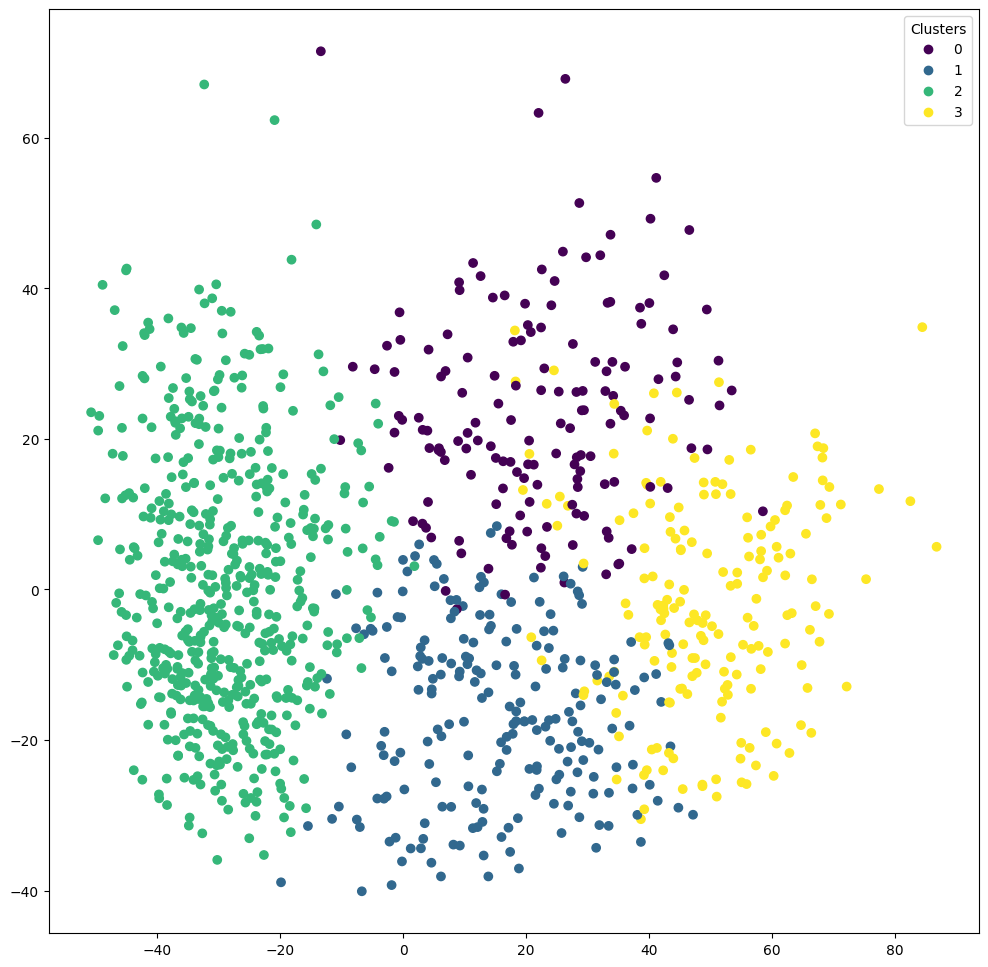

In [12]:
kmeans = KMeans(n_clusters=4, random_state=76101)
kmeans.fit(x)

pca = PCA(n_components=2, random_state=76101)
pca.fit(x)
y = pca.transform(x)

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot()
print(y.shape)
scatter = ax.scatter(y[:,0],y[:,1],c=kmeans.labels_)

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Clusters")


plt.show()

Copy files to Clusters folder

In [18]:
import shutil
kmeans = KMeans(n_clusters=4, random_state=76101)
kmeans.fit(x)
for idx in range(len(x)):
    shutil.copy(pottery[idx], os.getcwd() + f"\..\Clusters\C{kmeans.labels_[idx]}")
        

Note that a lot of the code below has been hardcoded specifically for the dataset I am working with.
Its structure can be followed to write code for a different dataset or to make it generic.

Count what percent of each location is in a given cluster

In [13]:
cluster_counts = {0:{"Banpo":0, "Banshan":0,"Machang":0, "Majiayao":0, "Miaodigou":0},
                  1:{"Banpo":0, "Banshan":0,"Machang":0, "Majiayao":0, "Miaodigou":0},
                  2:{"Banpo":0, "Banshan":0,"Machang":0, "Majiayao":0, "Miaodigou":0},
                  3:{"Banpo":0, "Banshan":0,"Machang":0, "Majiayao":0, "Miaodigou":0}}
def get_loc(filepath):
    fname = os.path.basename(filepath)
    loc = fname[:fname.index("_")]
    return loc
for idx in range(len(x)):
    cluster_counts[kmeans.labels_[idx]][get_loc(pottery[idx])] +=1
print(cluster_counts)
print(cluster_counts[3])


banpo_count = 115
banshan_count = 117
machang_count = 298
majiayao_count = 127
miaodigou_count = 449
loc_counts = [banpo_count, banshan_count, machang_count, majiayao_count, miaodigou_count]
cluster_percents = dict(cluster_counts)
for cluster, D in cluster_counts.items():
    for idx, loc in enumerate(D.keys()):
        cluster_percents[cluster][loc] = cluster_percents[cluster][loc]/loc_counts[idx]
print(cluster_percents[2])
# for cluster, vals in cluster_counts.items():
#     print(f"Cluster {cluster}")
#     total = sum(list(vals.values()))
#     for loc, count in vals.items():
        

{0: {'Banpo': 2, 'Banshan': 23, 'Machang': 105, 'Majiayao': 16, 'Miaodigou': 9}, 1: {'Banpo': 25, 'Banshan': 46, 'Machang': 100, 'Majiayao': 24, 'Miaodigou': 20}, 2: {'Banpo': 63, 'Banshan': 3, 'Machang': 31, 'Majiayao': 48, 'Miaodigou': 405}, 3: {'Banpo': 25, 'Banshan': 45, 'Machang': 62, 'Majiayao': 39, 'Miaodigou': 15}}
{'Banpo': 25, 'Banshan': 45, 'Machang': 62, 'Majiayao': 39, 'Miaodigou': 15}
{'Banpo': 0.5478260869565217, 'Banshan': 0.02564102564102564, 'Machang': 0.1040268456375839, 'Majiayao': 0.3779527559055118, 'Miaodigou': 0.9020044543429844}


Generate Bar Plot For a Cluster using the percentages of that location in the cluster

{'Banpo': 0.21739130434782608, 'Banshan': 0.38461538461538464, 'Machang': 0.2080536912751678, 'Majiayao': 0.30708661417322836, 'Miaodigou': 0.0334075723830735}


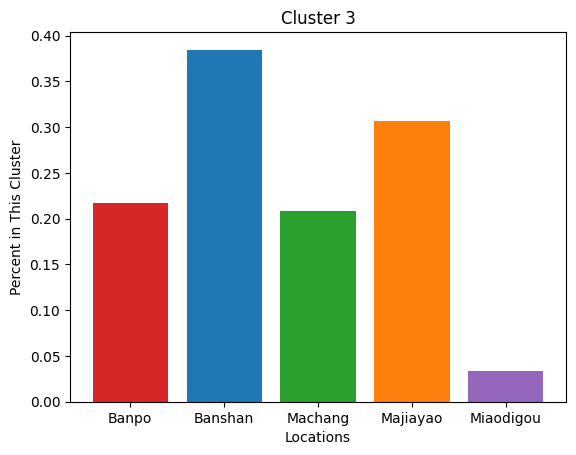

In [18]:
cluster = 3
D = cluster_percents[cluster]
print(D)
bar_colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:purple']
plt.bar(range(len(D)), list(D.values()), align='center', color = bar_colors)
plt.xticks(range(len(D)), list(D.keys()))
plt.xlabel("Locations")
plt.ylabel("Percent in This Cluster")
plt.title(f"Cluster {cluster}")
plt.show()